<a href="https://colab.research.google.com/github/BrendaLoznik/waterpumps/blob/main/3B.%20Modelling%20experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1 Housekeeping

### 1.1 Load libraries

In [ ]:
pip install catboost

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

#machine learning
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import VotingClassifier
from catboost import CatBoostClassifier
from sklearn.cluster import KMeans 
from sklearn.linear_model import LogisticRegression 

import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter(action='ignore', category=FutureWarning)

### 1.2 Custom functions

In [ ]:
def confusion_matrix_plotter (y_test,y_pred):
  fig, ax = plt.subplots(figsize=(8,5)) 
  data = confusion_matrix(y_test, y_pred)
  df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
  ax = sns.heatmap(df_cm, cmap='Blues', fmt='g' ,annot=True,annot_kws={"size": 14})
  ax.set_xlabel("Predicted")
  ax.set_ylabel ("Actual")
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
  ax.set_yticklabels(ax.get_xticklabels(), rotation=0)

In [ ]:
def feature_importances (model):
  features= X_train.columns
  importances = np.round(model.feature_importances_,3) 
  indices = np.argsort(importances)
  num_features = len(features)
  fig, ax = plt.subplots(figsize=(10,10)) 
  plt.barh(range(num_features), importances[indices[-num_features:]],  align='center')
  plt.yticks(range(num_features), [features[i] for i in indices[-num_features:]])
  plt.xlabel('Relative Importance')
  plt.title('Feature Importance')
plt.show()

### 1.3 Load data

In [ ]:
from google.colab import drive 
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train_labels = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpump-github/train_labels.csv')
train_values = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpump-github/train_values.csv', parse_dates = ['date_recorded' ],  na_values = [0, '0'])
test_values = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpump-github/test_values.csv', parse_dates = ['date_recorded' ] , na_values = [0, '0'])
final_df = pd.read_csv('/content/gdrive/MyDrive/Kaggle/Waterpump-github/final_df.csv')
final_df = final_df.drop('Unnamed: 0', axis=1)

In [ ]:
final_df.head()

,id,status_group,funder,installer,latitude,basin,region_code,public_meeting,extraction_type,extraction_type_class,payment_type,water_quality,quantity,source,waterpoint_type,longitude,permit,scheme_management,gps_height,population,age,season,amount_tsh_missing,region_district,authority_scheme
0,69572,functional,107,108,-9.86,1,2,1,1,0,0,6,1,8,1,34.94,0,7,1390,109,12,1,0,20,1
1,8776,functional,45,47,-2.15,4,12,1,1,0,2,6,2,5,1,34.70,1,2,1399,280,3,1,1,55,2
2,34310,functional,95,148,-3.82,5,13,1,1,0,5,6,1,0,2,37.46,1,7,686,250,4,2,0,52,1
3,67743,non functional,136,129,-11.16,7,25,1,11,5,2,6,0,3,2,38.49,1,7,263,58,27,2,1,76,1
4,19728,functional,95,7,-1.83,4,9,1,1,0,2,6,3,5,1,31.13,1,2,1328,532,15,0,1,22,2


# 2 Modelling

In [ ]:
#define train and test 
train_set = final_df [final_df ["id"].isin(train_values["id"])]
test_set =  final_df  [final_df  ["id"].isin(test_values["id"])]

In [ ]:
#define X and y for training the model
X= train_set.drop(['id', 'status_group'], axis=1)
y = train_set['status_group']

### **2.1 Best submission**

####**Baseline model performance**

In [ ]:
#define the models
models=[LogisticRegression(max_iter = 1000000,  random_state=42),
        KNeighborsClassifier(),
        DecisionTreeClassifier( random_state=42),
       RandomForestClassifier( random_state=42),
       XGBClassifier( random_state=42),
        BaggingClassifier( random_state=42), 
        AdaBoostClassifier( random_state=42),
        GradientBoostingClassifier( random_state=42),
       CatBoostClassifier( random_state=42)]

#create a list of model names
names =['Logistic Regression', 'KNN Classifier', 'Decision Tree Classifier', 'Random Forest Classifier',  'XGB Classifier', 'Bagging Classifier', 'AdaBoost Classifier', 'Gradient Boosting Classifier', 'Catboost Classifier']

#create empty lists for the accuracy and standard deviation
accuracy=[]
std = []

#peform 10-fold cross validaton on each model and append the results to the list
for model in models:
  cv = KFold(n_splits=10, shuffle = True,  random_state=1)
  n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
  mean_score = np.mean(n_scores)
  std_score = np.std(n_scores)
  accuracy.append(mean_score)
  std.append(std_score)

#create a dataframe of the model performances
d = {'Model':names,'Accuracy':accuracy, 'Std':std}   
score_df = pd.DataFrame(d)
score_df

,Model,Accuracy,Std
0,Logistic Regression,0.666510,0.006001
1,KNN Classifier,0.701140,0.007301
2,Decision Tree Classifier,0.756158,0.004169
3,Random Forest Classifier,0.804121,0.004219
4,XGB Classifier,0.742740,0.005622
5,Bagging Classifier,0.793599,0.003323
6,AdaBoost Classifier,0.723985,0.005083
7,Gradient Boosting Classifier,0.751174,0.005385
8,Catboost Classifier,0.796428,0.003599


####**Hyperparameter range plots**

Visualize the optimal number of n_estimators for a random forest and a bagging classifier.

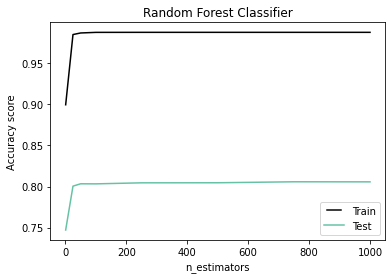

In [ ]:
#define X and y for training the model
X= train_set.drop(['id', 'status_group'], axis=1)
y = train_set['status_group']
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)

#determine accuracy for different levels of n_estimators
n_estimators = [1,  25,  50, 100, 250, 500, 750, 1000]
train_results = []
test_results = []

for estimator in n_estimators:
   rf = RandomForestClassifier(n_estimators=estimator, n_jobs=-1)
   rf.fit(X_train, y_train)
  #train accuracy
   train_pred = rf.predict(X_train)
   train_results.append(accuracy_score(y_train,train_pred))
  #test accuracy
   test_pred = rf.predict(X_test)
   test_results.append(accuracy_score(y_test, test_pred))

#plot  
from matplotlib.legend_handler import HandlerLine2D
line1, = plt.plot(n_estimators, train_results, color = 'k', label="Train")
line2, = plt.plot(n_estimators, test_results, color =  '#66c2a5', label="Test")
plt.legend(handler_map={line1: HandlerLine2D(numpoints=2)})
plt.ylabel("Accuracy score")
plt.xlabel("n_estimators")
plt.title("Random Forest Classifier")
plt.show()

#### **Best model**

My best model resulted in an accuracy of 0.8235 on the public board (rank 504). This model consisted of a weighted vote of 4 tuned tree-based models.

In [ ]:
#tuned models
rf = RandomForestClassifier(max_depth=30, max_features='log2', min_samples_split=7, n_estimators=225, random_state=42, warm_start=True)
xgb = XGBClassifier(max_depth =12, n_estimators= 200, colsample_bytree = 0.3, eta = 0.2, random_state = 42) 
cat = CatBoostClassifier(max_depth = 9, rsm = 0.2, iterations = 1000, random_state = 42)
bag = BaggingClassifier(max_features=0.4, n_estimators=1000, random_state=42) 

In [ ]:
# Create training and test sets: test size 0.2
X_train, X_test, y_train, y_test= train_test_split(X, y, test_size = 0.2, random_state=42, stratify=y)


vc = VotingClassifier([('rf', rf), ('xgb', xgb),('cat', cat), ('bag', bag)], voting = 'soft', weights = [0.85, 1, 0.85, 0.75])
                       
#fit and predict
vc.fit(X_train , y_train)
pred= vc .predict(X_test)
pred_train = vc .predict(X_train)


Accuracy score train: 0.9242197857699026
Accuracy score test: 0.8159090909090909
                         precision    recall  f1-score   support

             functional       0.80      0.91      0.85      6452
functional needs repair       0.64      0.28      0.39       863
         non functional       0.86      0.78      0.82      4565

               accuracy                           0.82     11880
              macro avg       0.77      0.66      0.69     11880
           weighted avg       0.81      0.82      0.81     11880



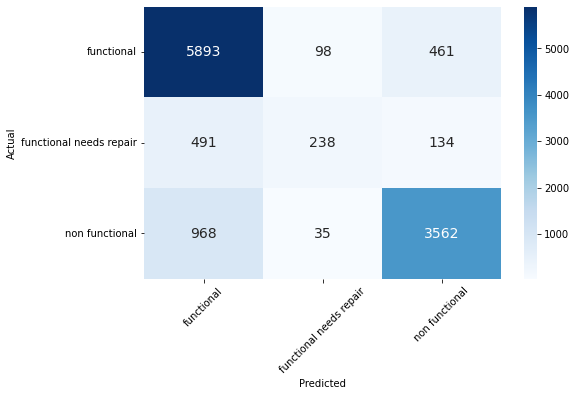

In [ ]:
#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_train ,pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, pred)))

#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, pred))

#heatmap
fig, ax = plt.subplots(figsize=(8,5)) 
data = confusion_matrix(y_test, pred)
df_cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
ax = sns.heatmap(df_cm, cmap='Blues', fmt='g' ,annot=True,annot_kws={"size": 14})
ax.set_xlabel("Predicted")
ax.set_ylabel ("Actual")
ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
ax.set_yticklabels(ax.get_xticklabels(), rotation=0)
plt.show()

### **2.2 Experiment 1 - Kmeans**

Is it possible to cluster the water pumps based on their characteristics? For each cluster I can calculate the percentage of functional, non-functional and pumps that need repairing. Can I improve model performance my including these percentages as variables to the dataset?

In [ ]:
#create a copy of the dataset
train_set_kmeans = train_set.copy()

#define X and y for training the model
X= train_set_kmeans.drop(['id', 'status_group'], axis=1)
y = train_set_kmeans['status_group']

In [ ]:
# transform data
scaler = StandardScaler()
scaled_features = scaler.fit_transform(X)

#create scaled df
scaled_data = pd.DataFrame(scaled_features , index=X.index, columns=X.columns)

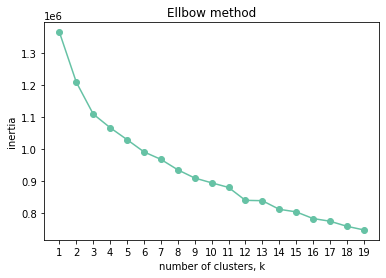

In [ ]:
#Create an ellbow plot to determine the optimal number of clusters
ks = range(1, 20)
inertias = []

for k in ks:
    # Create a KMeans instance with k clusters: model
    kmeans = KMeans(n_clusters=k).fit(scaled_data)
     
    # Append the inertia to the list of inertias
    inertias.append(kmeans.inertia_)
    
# Plot ks vs inertias
plt.plot(ks, inertias, '-o',  color =  '#66c2a5')
plt.xlabel('number of clusters, k')
plt.ylabel('inertia')
plt.title("Ellbow method")
plt.xticks(ks)
plt.show()

In [ ]:
#fit K means with 3 clusters
kmeans = KMeans(n_clusters=3, random_state =11 )
kmeans.fit(scaled_data)

# Calculate the cluster labels: labels
clusters = kmeans.predict(scaled_data)
train_set_kmeans["cluster"] = clusters

In [ ]:
#calculate percentage of status groups per cluster
grouped = train_set_kmeans.groupby(['cluster', 'status_group'])['id'].count().reset_index()

pivot = grouped.pivot(index = ['cluster'], columns = 'status_group')
mi=pivot .columns
mi.tolist()
ind = pd.Index([ str(e[1])  for e in mi.tolist()])
pivot .columns = ind

pivot['Pumps (#)'] = pivot['functional'] + pivot['non functional'] + pivot['functional needs repair']
pivot['Functional pumps (%)'] = round(pivot['functional'] / pivot['Pumps (#)'],2)
pivot['Non-functional pumps (%)'] = round(pivot['non functional'] / pivot['Pumps (#)'],2)
pivot['Functional need repair pumps (%)'] = round(pivot['functional needs repair'] / pivot['Pumps (#)'],2)

pivot = pivot.drop(['functional', 'functional needs repair', 'non functional'],axis=1)
pivot = pivot.reset_index()
pivot

,cluster,Pumps (#),Functional pumps (%),Non-functional pumps (%),Functional need repair pumps (%)
0,0,13923,0.48,0.47,0.04
1,1,23291,0.62,0.29,0.09
2,2,22185,0.50,0.43,0.07


In [ ]:
#add the cluster means to the dataframes
train_set_kmeans = train_set_kmeans.merge(pivot[['cluster', 'Functional pumps (%)', 'Non-functional pumps (%)', 'Functional need repair pumps (%)']], how = 'left', on = 'cluster')
train_set_kmeans.head()

,id,status_group,funder,installer,latitude,basin,region_code,public_meeting,extraction_type,extraction_type_class,payment_type,water_quality,quantity,source,waterpoint_type,longitude,permit,scheme_management,gps_height,population,age,season,amount_tsh_missing,region_district,authority_scheme,cluster,Functional pumps (%),Non-functional pumps (%),Functional need repair pumps (%)
0,69572,functional,107,108,-9.86,1,2,1,1,0,0,6,1,8,1,34.94,0,7,1390,109,12,1,0,20,1,1,0.62,0.29,0.09
1,8776,functional,45,47,-2.15,4,12,1,1,0,2,6,2,5,1,34.70,1,2,1399,280,3,1,1,55,2,1,0.62,0.29,0.09
2,34310,functional,95,148,-3.82,5,13,1,1,0,5,6,1,0,2,37.46,1,7,686,250,4,2,0,52,1,0,0.48,0.47,0.04
3,67743,non functional,136,129,-11.16,7,25,1,11,5,2,6,0,3,2,38.49,1,7,263,58,27,2,1,76,1,0,0.48,0.47,0.04
4,19728,functional,95,7,-1.83,4,9,1,1,0,2,6,3,5,1,31.13,1,2,1328,532,15,0,1,22,2,1,0.62,0.29,0.09


####**Baseline model performance**

In [ ]:
#define the models
models=[LogisticRegression(max_iter = 1000000,  random_state=42),
        KNeighborsClassifier(),
        DecisionTreeClassifier( random_state=42),
       RandomForestClassifier( random_state=42),
       XGBClassifier( random_state=42),
        BaggingClassifier( random_state=42), 
        AdaBoostClassifier( random_state=42),
        GradientBoostingClassifier( random_state=42),
       CatBoostClassifier( random_state=42)]

#create a list of model names
names =['Logistic Regression', 'KNN Classifier', 'Decision Tree Classifier', 'Random Forest Classifier',  'XGB Classifier', 'Bagging Classifier', 'AdaBoost Classifier', 'Gradient Boosting Classifier', 'Catboost Classifier']

#create empty lists for the accuracy and standard deviation
accuracy=[]
std = []

#peform 10-fold cross validaton on each model and append the results to the list
for model in models:
  cv = KFold(n_splits=10, shuffle = True,  random_state=1)
  n_scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1, error_score='raise')
  mean_score = np.mean(n_scores)
  std_score = np.std(n_scores)
  accuracy.append(mean_score)
  std.append(std_score)

#create a dataframe of the model performances
d = {'Model':names,'Accuracy':accuracy, 'Std':std}   
score_df = pd.DataFrame(d)
score_df

,Model,Accuracy,Std
0,Logistic Regression,0.666510,0.006001
1,KNN Classifier,0.701140,0.007301
2,Decision Tree Classifier,0.756158,0.004169
3,Random Forest Classifier,0.804121,0.004219
4,XGB Classifier,0.742740,0.005622
5,Bagging Classifier,0.793599,0.003323
6,AdaBoost Classifier,0.723985,0.005083
7,Gradient Boosting Classifier,0.751174,0.005385
8,Catboost Classifier,0.796428,0.003599


### **2.3 Experiment 2 - Specialized models**

Is it possible to create three sepperate models that are each specialized in predicting one of the three classes and combining them together to create a final prediction? 

In [ ]:
#create a copy of the dataset
train_set_sp = train_set.copy()

#define X and y for training the model
X= train_set_sp.drop(['id', 'status_group'], axis=1)
y = train_set_sp['status_group']

In [ ]:
#step 1: create three different y variables

#functional y:  functional =1, other classes are 0
y_functional = y.copy()
y_functional = y_functional .replace(['non functional'], 0)
y_functional  = y_functional.replace('functional needs repair', 0)
y_functional  = y_functional.replace('functional', 1)

#non-fuctional y: non-functional =1, other classes are 0
y_non_functional = y.copy()
y_non_functional = y_non_functional.replace(['non functional'], 1)
y_non_functional  = y_non_functional.replace('functional needs repair', 0)
y_non_functional = y_non_functional.replace('functional', 0)

#repair y: repair = 1, other classes are 0
y_repair = y.copy()
y_repair = y_repair.replace(['non functional'], 0)
y_repair  = y_repair.replace('functional needs repair', 1)
y_repair = y_repair.replace('functional', 0)

Note: the best models provided below were created using a slightly different subset of features and a different encoding strategy. The hyperparamter settings may not be the optimal parameters for the current dataset. 

#### **Functional model**

In [ ]:
#running this script on Google Colab takes too long

# Create training and test sets: test size 0.2
X_train, X_test, y_train, y_test= train_test_split(X, y_functional, test_size = 0.2, random_state=42)


param_grid = { 'n_estimators': [ 180, 200, 220, ],
             'max_features':['log2', ],
             'max_depth' : [70, 80, 90, 100],
             'min_samples_split':[ 7, 8,9]}


#Create a based model
rf =     RandomForestClassifier( random_state=42, warm_start = True)  

grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5,  verbose = 2,  scoring = 'accuracy')

#fitmodel
grid_search_rf .fit(X_train, y_train)

#print best parameters 
print('Best Score:', grid_search_rf .best_score_)
print('Parameters:', grid_search_rf .best_params_)
print('Best Model:', grid_search_rf .best_estimator_)



Accuracy score train: 0.9417496159430965
Accuracy score test: 0.8283670033670034

              precision    recall  f1-score   support

           0       0.84      0.77      0.80      5428
           1       0.82      0.87      0.85      6452

    accuracy                           0.83     11880
   macro avg       0.83      0.82      0.83     11880
weighted avg       0.83      0.83      0.83     11880



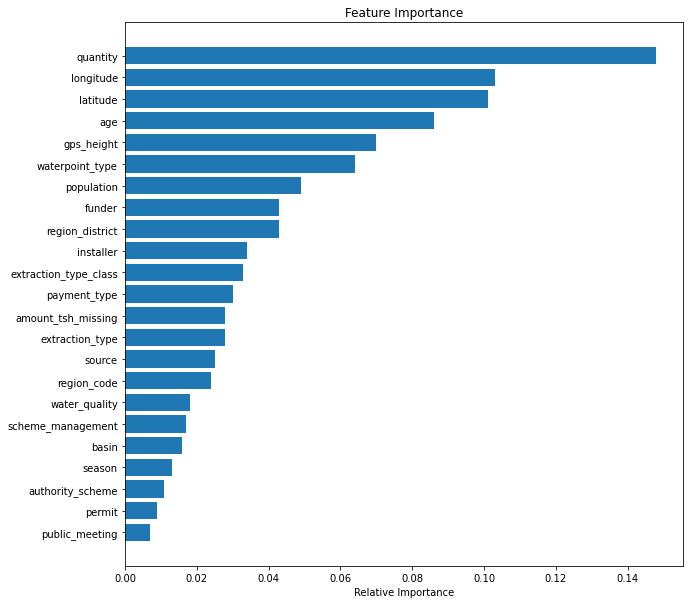

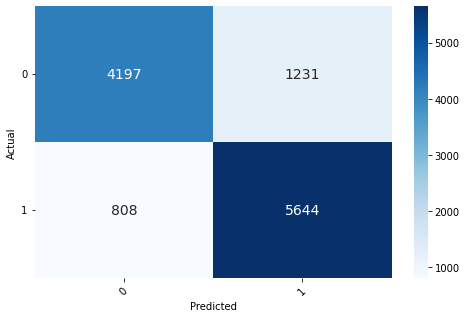

In [ ]:
#score model
best_model = RandomForestClassifier(max_depth=70, max_features='log2', min_samples_split=7, n_estimators=180, random_state=42, warm_start=True)

X_train, X_test, y_train, y_test= train_test_split(X, y_functional, test_size = 0.2, random_state=42 , stratify=y_functional)

#fit the best model
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)


#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, y_pred)))
print()

#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

feature_importances(best_model)

confusion_matrix_plotter(y_test, y_pred)

#### **Non-functional model**

In [ ]:
# Create training and test sets: test size 0.2
X_train, X_test, y_train, y_test= train_test_split(X, y_non_functional, test_size = 0.2, random_state=42)

param_grid = { 'n_estimators': [ 180, 200, 220, ],
             'max_features':['sqrt' ],
             'max_depth' : [30,40,50],
             'min_samples_split':[ 4,5,6]}

#Create a based model
rf =     RandomForestClassifier( random_state=42, warm_start = True)  

grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5,  verbose = 2,  scoring = 'accuracy')

#fitmodel
grid_search_rf .fit(X_train, y_train)

#print best parameters 
print('Best Score:', grid_search_rf .best_score_)
print('Parameters:', grid_search_rf .best_params_)
print('Best Model:', grid_search_rf .best_estimator_)


Accuracy score train: 0.9612365580083756
Accuracy score test: 0.8640572390572391

              precision    recall  f1-score   support

           0       0.86      0.92      0.89      7315
           1       0.86      0.77      0.81      4565

    accuracy                           0.86     11880
   macro avg       0.86      0.85      0.85     11880
weighted avg       0.86      0.86      0.86     11880



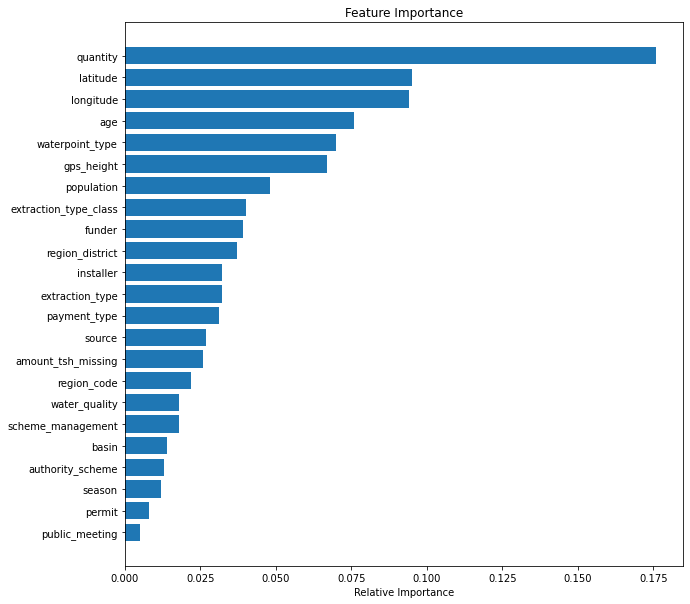

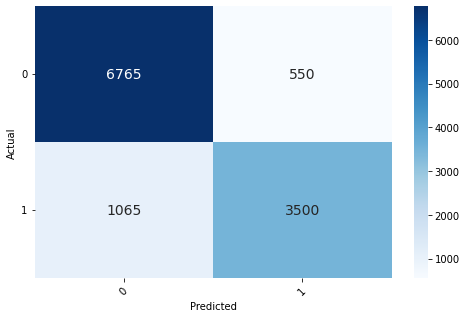

In [ ]:
#score model
best_model =  RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5,   n_estimators=180, random_state=42, warm_start=True)

X_train, X_test, y_train, y_test= train_test_split(X, y_non_functional, test_size = 0.2, random_state=42 , stratify=y_non_functional)

#fit the best model
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)


#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, y_pred)))
print()

#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

feature_importances(best_model)

confusion_matrix_plotter(y_test, y_pred)

#### **Funtional need repair model**

In [ ]:
# Create training and test sets: test size 0.2
X_train, X_test, y_train, y_test= train_test_split(X, y_repair, test_size = 0.2, random_state=42, stratify = y_repair)

param_grid = { 'n_estimators': [  125, 150, 175],
             'max_features':['sqrt'],
             'max_depth' : [12,15, 17 ,20, 25, 30],
             'min_samples_split':[18,9,10]}



#Create a based model
rf =     RandomForestClassifier( random_state=42, warm_start = True)  

grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, cv = 5,  verbose = 2,  scoring = 'accuracy')

#fitmodel
grid_search_rf .fit(X_train, y_train)

#print best parameters 
print('Best Score:', grid_search_rf .best_score_)
print('Parameters:', grid_search_rf .best_params_)
print('Best Model:', grid_search_rf .best_estimator_)


Accuracy score train: 0.9510511584839748
Accuracy score test: 0.937962962962963

              precision    recall  f1-score   support

           0       0.94      0.99      0.97     11017
           1       0.75      0.22      0.34       863

    accuracy                           0.94     11880
   macro avg       0.84      0.61      0.65     11880
weighted avg       0.93      0.94      0.92     11880



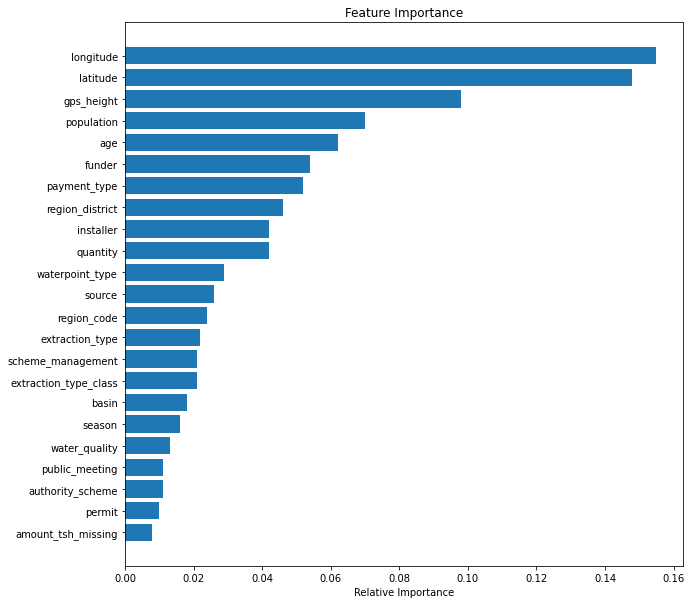

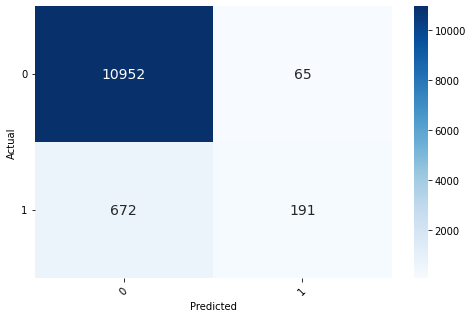

In [ ]:
#score model
best_model =  RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_split=9,  n_estimators=125, random_state=42, warm_start=True)

X_train, X_test, y_train, y_test= train_test_split(X, y_repair, test_size = 0.2, random_state=42 , stratify=y_repair)

#fit the best model
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
y_pred_train = best_model.predict(X_train)


#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, y_pred)))
print()

#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

feature_importances(best_model)

confusion_matrix_plotter(y_test, y_pred)

####**Stacking together**

In [ ]:
#tuned models
functional = RandomForestClassifier(max_depth=70, max_features='log2', min_samples_split=7,  n_estimators=180, random_state=42, warm_start=True)
non_functional = RandomForestClassifier(max_depth=30, max_features='sqrt', min_samples_split=5, n_estimators=180, random_state=42, warm_start=True)
repair = RandomForestClassifier(max_depth=20, max_features='sqrt', min_samples_split=9,    n_estimators=125, random_state=42, warm_start=True)


In [ ]:
#y cannot be categorical so we have to relabel it
y_encoded = y.copy()
y_encoded = y_encoded.replace(['non functional'], 0)
y_encoded  = y_encoded.replace('functional needs repair', 1)
y_encoded = y_encoded.replace('functional', 2)

Accuracy score train: 0.9101412066752247
Accuracy score test: 0.8087542087542088

              precision    recall  f1-score   support

           0       0.84      0.78      0.81      4559
           1       0.60      0.30      0.40       845
           2       0.80      0.90      0.85      6476

    accuracy                           0.81     11880
   macro avg       0.75      0.66      0.68     11880
weighted avg       0.80      0.81      0.80     11880



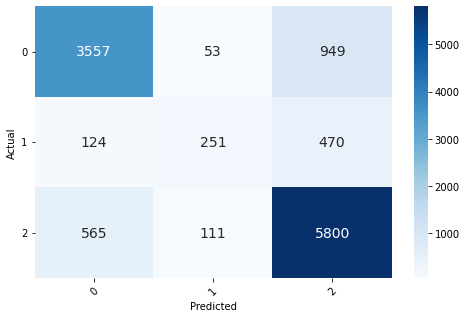

In [ ]:
#create stacking classifier
stack = StackingClassifier([('functional', functional), ('non_functional', non_functional), ('repair', repair)])

# Create training and test sets: test size 0.2
X_train, X_test, y_train, y_test= train_test_split(X, y_encoded, test_size = 0.2, random_state=42)

# fitting the model
stack.fit(X_train, y_train)

# make predictions for test data
y_pred = stack.predict(X_test)
y_pred_train = stack.predict(X_train)


#print best model scores on test data
print("Accuracy score train: {}".format(accuracy_score(y_train, y_pred_train)))
print("Accuracy score test: {}".format(accuracy_score(y_test, y_pred)))
print()

#print(confusion_matrix(y_test, y_pred))
print(classification_report(y_test, y_pred))

confusion_matrix_plotter(y_test, y_pred)